# Random Linear Projections Loss Performance on Classification Tasks

In this notebook we present the performance of the RLP loss proposed in the paper (citation will be added after the reviewing process), we compare RLP to Cross Entropy on a simple synthetic benchmark dataset that is the Moon dataset. We follow that with a study of RLP and Cross Entropy when built with Mixup.

## Training with the Full dataset with some noise:

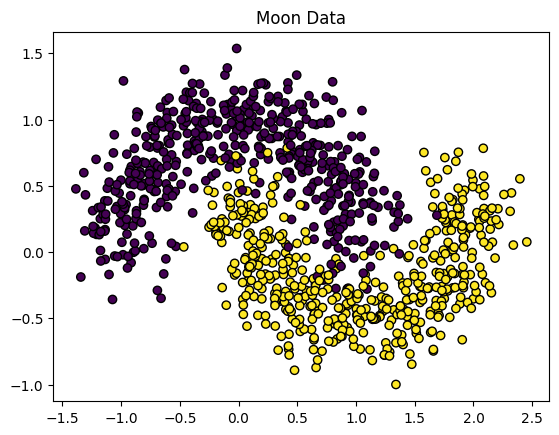

In [ ]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader


torch.manual_seed(42)

# Step 2: Generate and visualize the dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title('Moon Data')
plt.show()

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Step 4: Define the neural network model
class MoonClassifier(nn.Module):
    def __init__(self):
        super(MoonClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=50)
        self.output = nn.Linear(in_features=50, out_features=2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.output(x)
        return x

class MoonClassifier_RLP(nn.Module):
    def __init__(self):
        super(MoonClassifier_RLP, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=50)
        self.output = nn.Linear(in_features=50, out_features=1)  # Only 1 output neuron

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.output(x)) # Ensure output is 1D
        return x

In [ ]:
def balanced_batch_generator_reg(data, labels, M, K):
    num_samples = len(data)
    selected_batches = set()
    all_indices = np.arange(num_samples)

    # Make sure each data point is in at least one batch
    np.random.shuffle(all_indices)

    # Sample until we obtain K unique batches
    while len(selected_batches) < K:
        # Generate indices and shuffle them
        all_indices = np.arange(num_samples)
        np.random.shuffle(all_indices)

        # Iterate over data and form batches of size M
        for i in range(0, num_samples, M):
            batch_indices = tuple(sorted(all_indices[i:i+M]))
            if batch_indices not in selected_batches:
                if i + M > num_samples:  # skip batches smaller than N
                  continue
                selected_batches.add(batch_indices)

            if len(selected_batches) >= K:
                break

    # Transform the set to a list
    selected_batches = list(selected_batches)

    # Yield data batches with their labels
    for indices in selected_batches:
        yield data[np.array(indices)], labels[np.array(indices)]

In [ ]:
# [Steps 1-5 remain unchanged]

from sklearn.metrics import recall_score,f1_score


iterations = 5
num_epochs = 200
batch_size = 3
num_batches = 100

y_train_rlp = y_train.float().unsqueeze(1)  # Convert to float and add an extra dimension
y_test_rlp = y_test.float().unsqueeze(1)

unique_batches = list(balanced_batch_generator_reg(X_train, y_train_rlp, batch_size, num_batches))

# Lists to hold accuracy and recall values for both loss types
accuracy_bce_array = np.zeros((num_epochs,iterations))
recall_bce_array = np.zeros((num_epochs,iterations))
accuracy_rlp_array = np.zeros((num_epochs,iterations))
recall_rlp_array = np.zeros((num_epochs,iterations))

for i in range(iterations):
    # Reset models
    model_bce = MoonClassifier()
    model_rlp = MoonClassifier_RLP()
    optimizer_bce = optim.Adam(model_bce.parameters(), lr=1e-3)
    optimizer_rlp = optim.Adam(model_rlp.parameters(), lr=1e-3)
    criterion_bce = nn.CrossEntropyLoss()
    criterion_rlp = nn.MSELoss()

    # Convert labels for BCE
    y_train_bce = y_train.long()
    y_test_bce = y_test.long()

    # Convert labels for RLP
    y_train_rlp = y_train.float().unsqueeze(1)
    y_test_rlp = y_test.float().unsqueeze(1)


    for epoch in range(num_epochs):
        # Training loop for BCE
        optimizer_bce.zero_grad()
        outputs_bce = model_bce(X_train)
        loss_bce = criterion_bce(outputs_bce, y_train_bce)
        loss_bce.backward()
        optimizer_bce.step()

        # Training loop for RLP
        for batch_X, batch_y in unique_batches:
            model_rlp.train()
            optimizer_rlp.zero_grad()
            outputs_rlp = model_rlp(batch_X)
            reg_matrix = torch.linalg.pinv(batch_X.T @ batch_X) @ batch_X.T
            c = reg_matrix @ batch_y
            c_pred = reg_matrix @ outputs_rlp
            loss_rlp = criterion_rlp(batch_X @ c_pred , batch_X @ c )
            loss_rlp.backward()
            optimizer_rlp.step()

        with torch.no_grad():
            outputs_bce_test = model_bce(X_test)
            _, predicted_bce = torch.max(outputs_bce_test, 1)
            accuracy_bce_array[epoch,i] = (predicted_bce == y_test_bce).sum().item() / len(y_test) * 100
            recall_bce_array[epoch,i] = f1_score(y_test_bce, predicted_bce)


        # Evaluation for RLP
        with torch.no_grad():
            outputs_rlp_test = model_rlp(X_test)
            predicted_rlp = (outputs_rlp_test > 0.5).float()
            accuracy_rlp_array[epoch,i] = (predicted_rlp == y_test_rlp).sum().item() / len(y_test) * 100
            recall_rlp_array[epoch,i] = f1_score(y_test_rlp.numpy(), predicted_rlp.numpy())




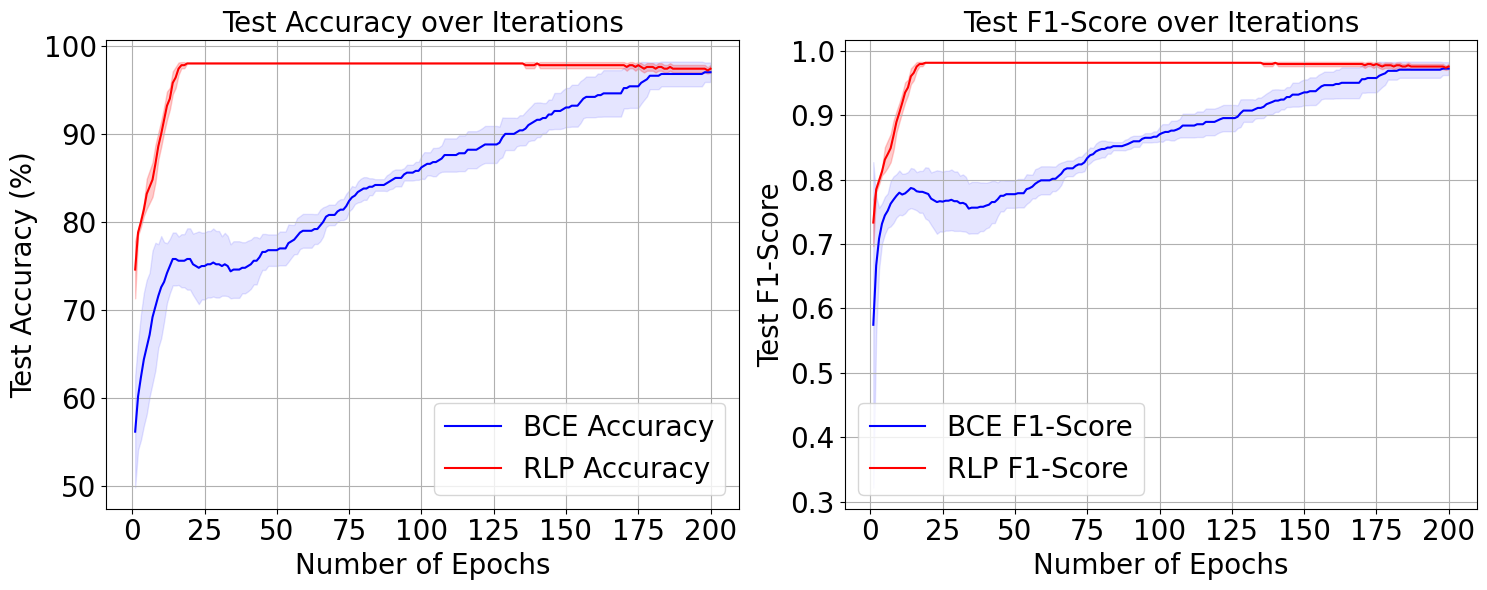

In [ ]:
# Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=1)
    std_error = np.std(data, axis=1) / np.sqrt(data.shape[1])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci

# Calculate means and confidence intervals for accuracy and recall
mean_accuracy_bce, ci_accuracy_bce = compute_mean_and_CI(accuracy_bce_array)
mean_accuracy_rlp, ci_accuracy_rlp = compute_mean_and_CI(accuracy_rlp_array)
mean_recall_bce, ci_recall_bce = compute_mean_and_CI(recall_bce_array)
mean_recall_rlp, ci_recall_rlp = compute_mean_and_CI(recall_rlp_array)

# Plot the results
epochs_range = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
# BCE Accuracy
plt.fill_between(epochs_range, mean_accuracy_bce - ci_accuracy_bce, mean_accuracy_bce + ci_accuracy_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_accuracy_bce, 'b-', label="BCE Accuracy", zorder=15)

# RLP Accuracy
plt.fill_between(epochs_range, mean_accuracy_rlp - ci_accuracy_rlp, mean_accuracy_rlp + ci_accuracy_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_accuracy_rlp, 'r-', label="RLP Accuracy", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test Accuracy (%)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test Accuracy over Iterations', fontsize=20)

# Plotting recall
plt.subplot(1, 2, 2)
# BCE Recall
plt.fill_between(epochs_range, mean_recall_bce - ci_recall_bce, mean_recall_bce + ci_recall_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_recall_bce, 'b-', label="BCE F1-Score", zorder=15)

# RLP Recall
plt.fill_between(epochs_range, mean_recall_rlp - ci_recall_rlp, mean_recall_rlp + ci_recall_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_recall_rlp, 'r-', label="RLP F1-Score", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test F1-Score", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test F1-Score over Iterations', fontsize=20)

plt.tight_layout()
#plt.savefig("moons_rlp_bce.pdf", format="pdf", dpi=600)
plt.show()


### Add Mixup augmentation

Now, we add mixup and train the augmented data using Cross Entropy Loss. We also use mixup with RLP loss in top of the generated hyperplanes.

In [ ]:
# [Steps 1-5 remain unchanged]

from sklearn.metrics import recall_score,f1_score


iterations = 5
num_epochs = 200
batch_size = 3
num_batches = 100

y_train_rlp = y_train.float().unsqueeze(1)  # Convert to float and add an extra dimension
y_test_rlp = y_test.float().unsqueeze(1)

unique_batches = list(balanced_batch_generator_reg(X_train, y_train_rlp, batch_size, num_batches))
np.random.shuffle(unique_batches)  # Shuffle the batches for the second iterator
unique_batches2 = list(unique_batches)

# Lists to hold accuracy and recall values for both loss types
accuracy_bce_array = np.zeros((num_epochs,iterations))
recall_bce_array = np.zeros((num_epochs,iterations))
accuracy_rlp_array = np.zeros((num_epochs,iterations))
recall_rlp_array = np.zeros((num_epochs,iterations))

for i in range(iterations):
    # Reset models
    model_bce = MoonClassifier()
    model_rlp = MoonClassifier_RLP()
    optimizer_bce = optim.Adam(model_bce.parameters(), lr=1e-3)
    optimizer_rlp = optim.Adam(model_rlp.parameters(), lr=1e-3)
    criterion_bce = nn.CrossEntropyLoss()
    criterion_rlp = nn.MSELoss()

    # Convert labels for BCE
    y_train_bce = y_train.long()
    y_test_bce = y_test.long()


    batch_size_bce = 500
    train_dataset = TensorDataset(X_train, y_train_bce)
    train_dataloader = DataLoader(train_dataset, batch_size_bce, shuffle=True)
    train_dataloader_2 = DataLoader(train_dataset, batch_size_bce, shuffle=True)

     # Convert labels for RLP
    y_train_rlp = y_train.float().unsqueeze(1)
    y_test_rlp = y_test.float().unsqueeze(1)


    for epoch in range(num_epochs):
        epoch_loss = 0
        # Training loop for BCE
        #optimizer_bce.zero_grad()
        #outputs_bce = model_bce(X_train)
        #loss_bce = criterion_bce(outputs_bce, y_train_bce)
        #loss_bce.backward()
        #optimizer_bce.step()

        # y1, y2 should be one-hot vectors
        for (x1, y1), (x2, y2) in zip(train_dataloader, train_dataloader_2):
            model_bce.train()
            alpha = 0.15
            lam = np.random.beta(alpha, alpha)
            x = lam * x1 + (1. - lam) * x2
            y = lam * y1 + (1. - lam) * y2
            y = torch.LongTensor(y.numpy())

            optimizer_bce.zero_grad()
            outputs = model_bce(x)
            loss = criterion_bce(outputs, y)

            # Backward pass
            loss.backward()
            optimizer_bce.step()

            epoch_loss += loss.item()
        # Training loop for RLP
        for (batch_X, batch_y), (batch_X2, batch_y2) in zip(unique_batches, unique_batches2):
            model_rlp.train()
            alpha = 0.15
            lam = np.random.beta(alpha, alpha)
            x = lam * batch_X + (1. - lam) * batch_X2
            y = lam * batch_y + (1. - lam) * batch_y2
            optimizer_rlp.zero_grad()
            outputs_rlp = model_rlp(x)
            reg_matrix = torch.linalg.pinv(x.T @ x) @ x.T
            c = reg_matrix @ y
            c_pred = reg_matrix @ outputs_rlp
            loss_rlp = criterion_rlp(batch_X @ c_pred , batch_X @ c )
            loss_rlp.backward()
            optimizer_rlp.step()

        with torch.no_grad():
            outputs_bce_test = model_bce(X_test)
            _, predicted_bce = torch.max(outputs_bce_test, 1)
            accuracy_bce_array[epoch,i] = (predicted_bce == y_test_bce).sum().item() / len(y_test) * 100
            recall_bce_array[epoch,i] = f1_score(y_test_bce, predicted_bce)


        # Evaluation for RLP
        with torch.no_grad():
            outputs_rlp_test = model_rlp(X_test)
            predicted_rlp = (outputs_rlp_test > 0.5).float()
            accuracy_rlp_array[epoch,i] = (predicted_rlp == y_test_rlp).sum().item() / len(y_test) * 100
            recall_rlp_array[epoch,i] = f1_score(y_test_rlp.numpy(), predicted_rlp.numpy())

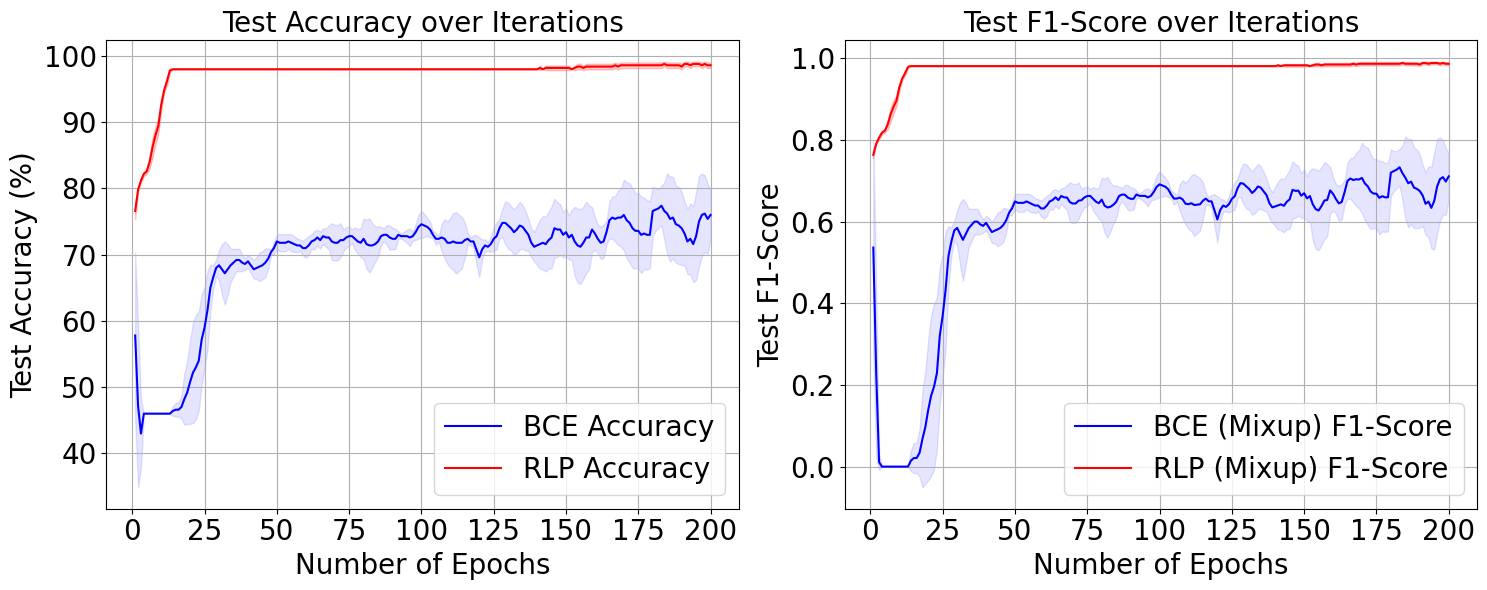

In [ ]:
# Calculate means and confidence intervals for accuracy and recall
mean_accuracy_bce, ci_accuracy_bce = compute_mean_and_CI(accuracy_bce_array)
mean_accuracy_rlp, ci_accuracy_rlp = compute_mean_and_CI(accuracy_rlp_array)
mean_recall_bce, ci_recall_bce = compute_mean_and_CI(recall_bce_array)
mean_recall_rlp, ci_recall_rlp = compute_mean_and_CI(recall_rlp_array)

# Plot the results
epochs_range = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
# BCE Accuracy
plt.fill_between(epochs_range, mean_accuracy_bce - ci_accuracy_bce, mean_accuracy_bce + ci_accuracy_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_accuracy_bce, 'b-', label="BCE Accuracy", zorder=15)

# RLP Accuracy
plt.fill_between(epochs_range, mean_accuracy_rlp - ci_accuracy_rlp, mean_accuracy_rlp + ci_accuracy_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_accuracy_rlp, 'r-', label="RLP Accuracy", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test Accuracy (%)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test Accuracy over Iterations', fontsize=20)

# Plotting recall
plt.subplot(1, 2, 2)
# BCE Recall
plt.fill_between(epochs_range, mean_recall_bce - ci_recall_bce, mean_recall_bce + ci_recall_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_recall_bce, 'b-', label="BCE (Mixup) F1-Score", zorder=15)

# RLP Recall
plt.fill_between(epochs_range, mean_recall_rlp - ci_recall_rlp, mean_recall_rlp + ci_recall_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_recall_rlp, 'r-', label="RLP (Mixup) F1-Score", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test F1-Score", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test F1-Score over Iterations', fontsize=20)

plt.tight_layout()
#plt.savefig("moons_rlp_bce.pdf", format="pdf", dpi=600)
plt.show()

# The Scarce Data Regime

In this section, we will repeat the same experiments using only $25$ training data points. We also only use 10 batches to train RLP.

In [ ]:
X, y = make_moons(n_samples=500, noise=0.1, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
# [Steps 1-5 remain unchanged]

from sklearn.metrics import recall_score,f1_score


iterations = 5
num_epochs = 200
batch_size = 3
num_batches = 10

y_train_rlp = y_train.float().unsqueeze(1)  # Convert to float and add an extra dimension
y_test_rlp = y_test.float().unsqueeze(1)

unique_batches = list(balanced_batch_generator_reg(X_train, y_train_rlp, batch_size, num_batches))

# Lists to hold accuracy and recall values for both loss types
accuracy_bce_array = np.zeros((num_epochs,iterations))
recall_bce_array = np.zeros((num_epochs,iterations))
accuracy_rlp_array = np.zeros((num_epochs,iterations))
recall_rlp_array = np.zeros((num_epochs,iterations))

for i in range(iterations):
    # Reset models
    model_bce = MoonClassifier()
    model_rlp = MoonClassifier_RLP()
    optimizer_bce = optim.Adam(model_bce.parameters(), lr=1e-3)
    optimizer_rlp = optim.Adam(model_rlp.parameters(), lr=1e-3)
    criterion_bce = nn.CrossEntropyLoss()
    criterion_rlp = nn.MSELoss()

    # Convert labels for BCE
    y_train_bce = y_train.long()
    y_test_bce = y_test.long()

    # Convert labels for RLP
    y_train_rlp = y_train.float().unsqueeze(1)
    y_test_rlp = y_test.float().unsqueeze(1)

    # Lists to hold intermediate values
    acc_bce, recall_bce, acc_rlp, recall_rlp = [], [], [], []

    for epoch in range(num_epochs):
        # Training loop for BCE
        optimizer_bce.zero_grad()
        outputs_bce = model_bce(X_train)
        loss_bce = criterion_bce(outputs_bce, y_train_bce)
        loss_bce.backward()
        optimizer_bce.step()

        # Training loop for RLP
        for batch_X, batch_y in unique_batches:
            model_rlp.train()
            optimizer_rlp.zero_grad()
            outputs_rlp = model_rlp(batch_X)
            reg_matrix = torch.linalg.pinv(batch_X.T @ batch_X) @ batch_X.T
            c = reg_matrix @ batch_y
            c_pred = reg_matrix @ outputs_rlp
            loss_rlp = criterion_rlp(batch_X @ c_pred , batch_X @ c )
            loss_rlp.backward()
            optimizer_rlp.step()

        with torch.no_grad():
            outputs_bce_test = model_bce(X_test)
            _, predicted_bce = torch.max(outputs_bce_test, 1)
            accuracy_bce_array[epoch,i] = (predicted_bce == y_test_bce).sum().item() / len(y_test) * 100
            recall_bce_array[epoch,i] = f1_score(y_test_bce, predicted_bce)


        # Evaluation for RLP
        with torch.no_grad():
            outputs_rlp_test = model_rlp(X_test)
            predicted_rlp = (outputs_rlp_test > 0.5).float()
            accuracy_rlp_array[epoch,i] = (predicted_rlp == y_test_rlp).sum().item() / len(y_test) * 100
            recall_rlp_array[epoch,i] = f1_score(y_test_rlp.numpy(), predicted_rlp.numpy())

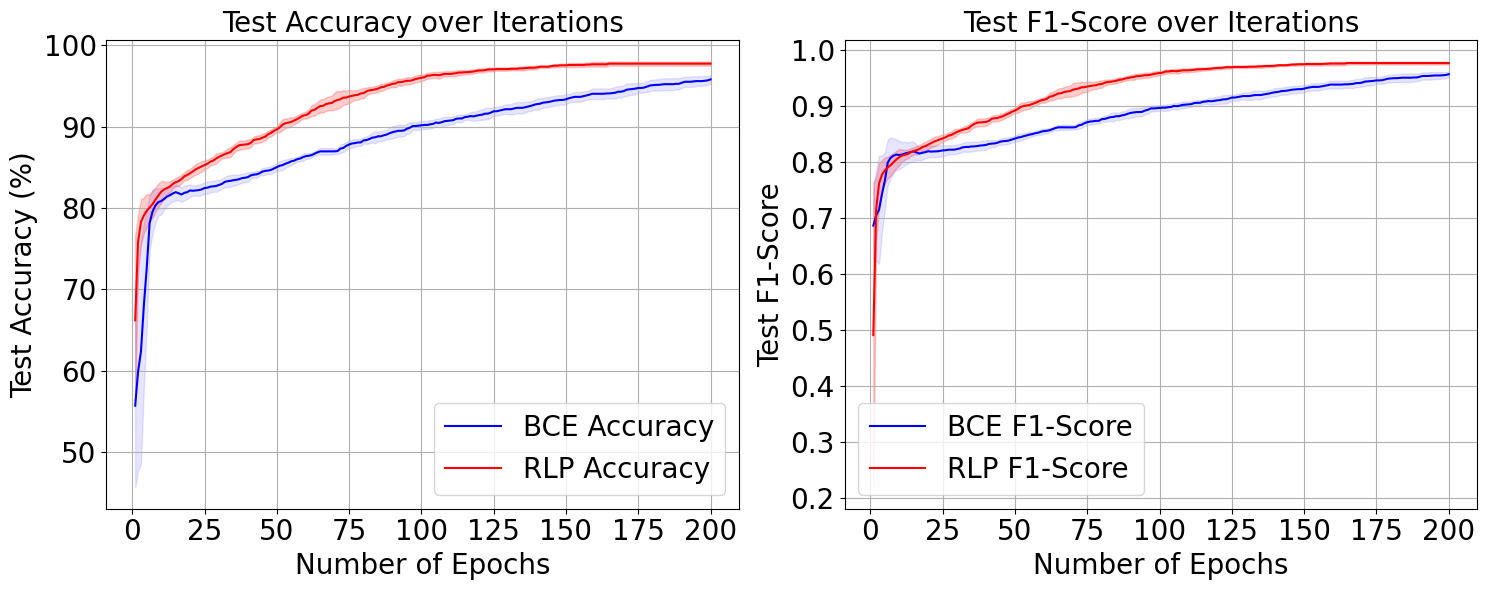

In [ ]:
# Calculate means and confidence intervals for accuracy and recall
mean_accuracy_bce, ci_accuracy_bce = compute_mean_and_CI(accuracy_bce_array)
mean_accuracy_rlp, ci_accuracy_rlp = compute_mean_and_CI(accuracy_rlp_array)
mean_recall_bce, ci_recall_bce = compute_mean_and_CI(recall_bce_array)
mean_recall_rlp, ci_recall_rlp = compute_mean_and_CI(recall_rlp_array)

# Plot the results
epochs_range = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
# BCE Accuracy
plt.fill_between(epochs_range, mean_accuracy_bce - ci_accuracy_bce, mean_accuracy_bce + ci_accuracy_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_accuracy_bce, 'b-', label="BCE Accuracy", zorder=15)

# RLP Accuracy
plt.fill_between(epochs_range, mean_accuracy_rlp - ci_accuracy_rlp, mean_accuracy_rlp + ci_accuracy_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_accuracy_rlp, 'r-', label="RLP Accuracy", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test Accuracy (%)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test Accuracy over Iterations', fontsize=20)

# Plotting recall
plt.subplot(1, 2, 2)
# BCE Recall
plt.fill_between(epochs_range, mean_recall_bce - ci_recall_bce, mean_recall_bce + ci_recall_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_recall_bce, 'b-', label="BCE F1-Score", zorder=15)

# RLP Recall
plt.fill_between(epochs_range, mean_recall_rlp - ci_recall_rlp, mean_recall_rlp + ci_recall_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_recall_rlp, 'r-', label="RLP F1-Score", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test F1-Score", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test F1-Score over Iterations', fontsize=20)

plt.tight_layout()
#plt.savefig("moons_rlp_bce.pdf", format="pdf", dpi=600)
plt.show()

### Mixup on top in the Small Data regime

In [ ]:
# [Steps 1-5 remain unchanged]

from sklearn.metrics import recall_score,f1_score


iterations = 5
num_epochs = 200
batch_size = 3
num_batches = 10

y_train_rlp = y_train.float().unsqueeze(1)  # Convert to float and add an extra dimension
y_test_rlp = y_test.float().unsqueeze(1)

unique_batches = list(balanced_batch_generator_reg(X_train, y_train_rlp, batch_size, num_batches))
np.random.shuffle(unique_batches)  # Shuffle the batches for the second iterator
unique_batches2 = list(unique_batches)

# Lists to hold accuracy and recall values for both loss types
accuracy_bce_array = np.zeros((num_epochs,iterations))
recall_bce_array = np.zeros((num_epochs,iterations))
accuracy_rlp_array = np.zeros((num_epochs,iterations))
recall_rlp_array = np.zeros((num_epochs,iterations))

for i in range(iterations):
    # Reset models
    model_bce = MoonClassifier()
    model_rlp = MoonClassifier_RLP()
    optimizer_bce = optim.Adam(model_bce.parameters(), lr=1e-3)
    optimizer_rlp = optim.Adam(model_rlp.parameters(), lr=1e-3)
    criterion_bce = nn.CrossEntropyLoss()
    criterion_rlp = nn.MSELoss()

    # Convert labels for BCE
    y_train_bce = y_train.long()
    y_test_bce = y_test.long()


    batch_size_bce = 500
    train_dataset = TensorDataset(X_train, y_train_bce)
    train_dataloader = DataLoader(train_dataset, batch_size_bce, shuffle=True)
    train_dataloader_2 = DataLoader(train_dataset, batch_size_bce, shuffle=True)

     # Convert labels for RLP
    y_train_rlp = y_train.float().unsqueeze(1)
    y_test_rlp = y_test.float().unsqueeze(1)


    for epoch in range(num_epochs):
        epoch_loss = 0
        # Training loop for BCE
        #optimizer_bce.zero_grad()
        #outputs_bce = model_bce(X_train)
        #loss_bce = criterion_bce(outputs_bce, y_train_bce)
        #loss_bce.backward()
        #optimizer_bce.step()

        # y1, y2 should be one-hot vectors
        for (x1, y1), (x2, y2) in zip(train_dataloader, train_dataloader_2):
            model_bce.train()
            alpha = 0.15
            lam = np.random.beta(alpha, alpha)
            x = lam * x1 + (1. - lam) * x2
            y = lam * y1 + (1. - lam) * y2
            y = torch.LongTensor(y.numpy())

            optimizer_bce.zero_grad()
            outputs = model_bce(x)
            loss = criterion_bce(outputs, y)

            # Backward pass
            loss.backward()
            optimizer_bce.step()

            epoch_loss += loss.item()
        # Training loop for RLP
        for (batch_X, batch_y), (batch_X2, batch_y2) in zip(unique_batches, unique_batches2):
            model_rlp.train()
            alpha = 0.15
            lam = np.random.beta(alpha, alpha)
            x = lam * batch_X + (1. - lam) * batch_X2
            y = lam * batch_y + (1. - lam) * batch_y2
            optimizer_rlp.zero_grad()
            outputs_rlp = model_rlp(x)
            reg_matrix = torch.linalg.pinv(x.T @ x) @ x.T
            c = reg_matrix @ y
            c_pred = reg_matrix @ outputs_rlp
            loss_rlp = criterion_rlp(batch_X @ c_pred , batch_X @ c )
            loss_rlp.backward()
            optimizer_rlp.step()

        with torch.no_grad():
            outputs_bce_test = model_bce(X_test)
            _, predicted_bce = torch.max(outputs_bce_test, 1)
            accuracy_bce_array[epoch,i] = (predicted_bce == y_test_bce).sum().item() / len(y_test) * 100
            recall_bce_array[epoch,i] = f1_score(y_test_bce, predicted_bce)


        # Evaluation for RLP
        with torch.no_grad():
            outputs_rlp_test = model_rlp(X_test)
            predicted_rlp = (outputs_rlp_test > 0.5).float()
            accuracy_rlp_array[epoch,i] = (predicted_rlp == y_test_rlp).sum().item() / len(y_test) * 100
            recall_rlp_array[epoch,i] = f1_score(y_test_rlp.numpy(), predicted_rlp.numpy())

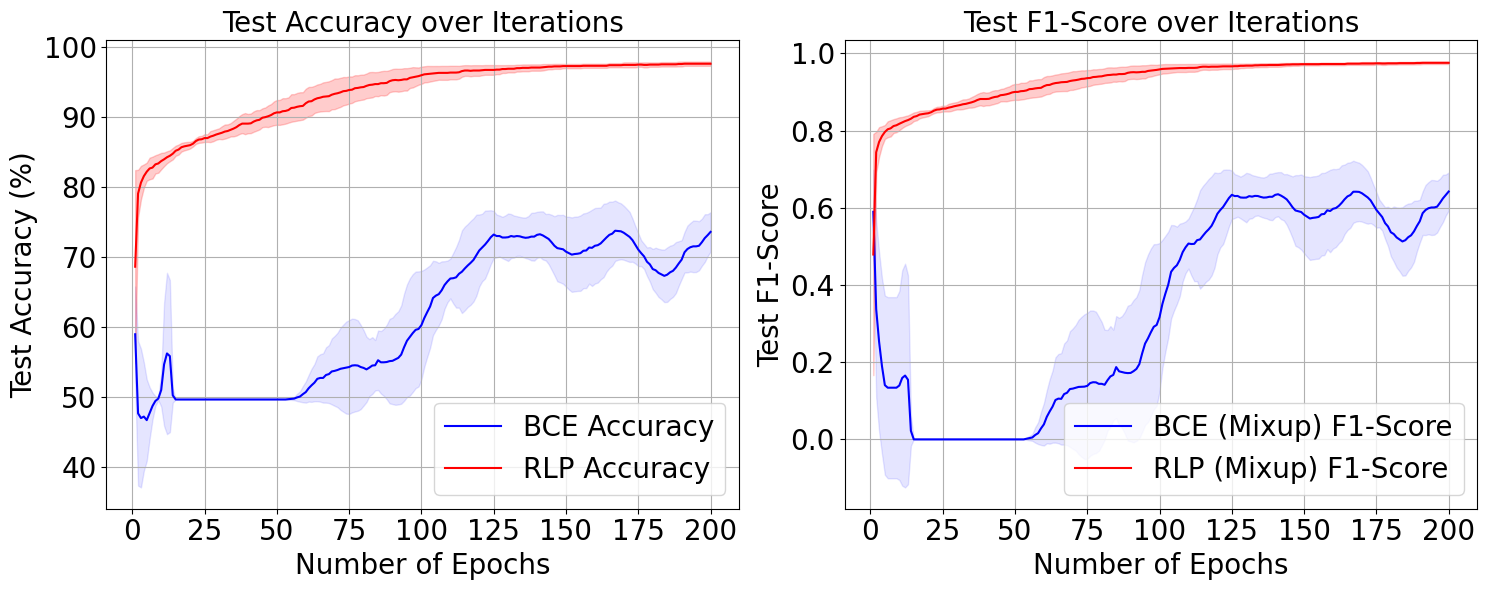

In [ ]:
# Calculate means and confidence intervals for accuracy and recall
mean_accuracy_bce, ci_accuracy_bce = compute_mean_and_CI(accuracy_bce_array)
mean_accuracy_rlp, ci_accuracy_rlp = compute_mean_and_CI(accuracy_rlp_array)
mean_recall_bce, ci_recall_bce = compute_mean_and_CI(recall_bce_array)
mean_recall_rlp, ci_recall_rlp = compute_mean_and_CI(recall_rlp_array)

# Plot the results
epochs_range = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
# BCE Accuracy
plt.fill_between(epochs_range, mean_accuracy_bce - ci_accuracy_bce, mean_accuracy_bce + ci_accuracy_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_accuracy_bce, 'b-', label="BCE Accuracy", zorder=15)

# RLP Accuracy
plt.fill_between(epochs_range, mean_accuracy_rlp - ci_accuracy_rlp, mean_accuracy_rlp + ci_accuracy_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_accuracy_rlp, 'r-', label="RLP Accuracy", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test Accuracy (%)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test Accuracy over Iterations', fontsize=20)

# Plotting recall
plt.subplot(1, 2, 2)
# BCE Recall
plt.fill_between(epochs_range, mean_recall_bce - ci_recall_bce, mean_recall_bce + ci_recall_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_recall_bce, 'b-', label="BCE (Mixup) F1-Score", zorder=15)

# RLP Recall
plt.fill_between(epochs_range, mean_recall_rlp - ci_recall_rlp, mean_recall_rlp + ci_recall_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_recall_rlp, 'r-', label="RLP (Mixup) F1-Score", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test F1-Score", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test F1-Score over Iterations', fontsize=20)

plt.tight_layout()
#plt.savefig("moons_rlp_bce.pdf", format="pdf", dpi=600)
plt.show()